# Decoding from a CEBRA embedding

In this notebook, we show how to:

- decode labels from a CEBRA embedding.
- evaluate and compare the decoding performances for embeddings obtained from different hypotheses.

It is based on what was presented in [Figure 2.d.](https://cebra.ai/docs/cebra-figures/figures/Figure2.html) of Schneider, Lee, Mathis.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from cebra import CEBRA

In [2]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

C:\Users\lucaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\cebra\datasets\monkey_reaching.py:35: UserWarning: Could not import the nlb_tools package required for data loading of cebra.datasets.monkey_reaching. Dataset will not be available. If required, you can install the dataset by running pip install git+https://github.com/neurallatents/nlb_tools.
  warnings.warn(
C:\Users\lucaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\cebra\__init__.py:99: UserWarning: Your code triggered a lazy import of cebra.datasets. While this will (likely) work, it is recommended to add an explicit import statement to you code instead. To disable this warning, you can run ``cebra.allow_lazy_imports()``.
  warnings.warn(


**------------------- BEGINNING OF TRAINING SECTION -------------------**

## Train the models

*[This can be skipped if you already saved the models].*

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

In [3]:
max_iterations = 500 #default is 5000.
output_dimension = 32 #here, we set as a variable for hypothesis testing below.

In [4]:
def split_data(data, test_ratio):

    split_idx = int(len(data)* (1-test_ratio))
    neural_train = data.neural[:split_idx]
    neural_test = data.neural[split_idx:]
    label_train = data.continuous_index[:split_idx]
    label_test = data.continuous_index[split_idx:]

    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

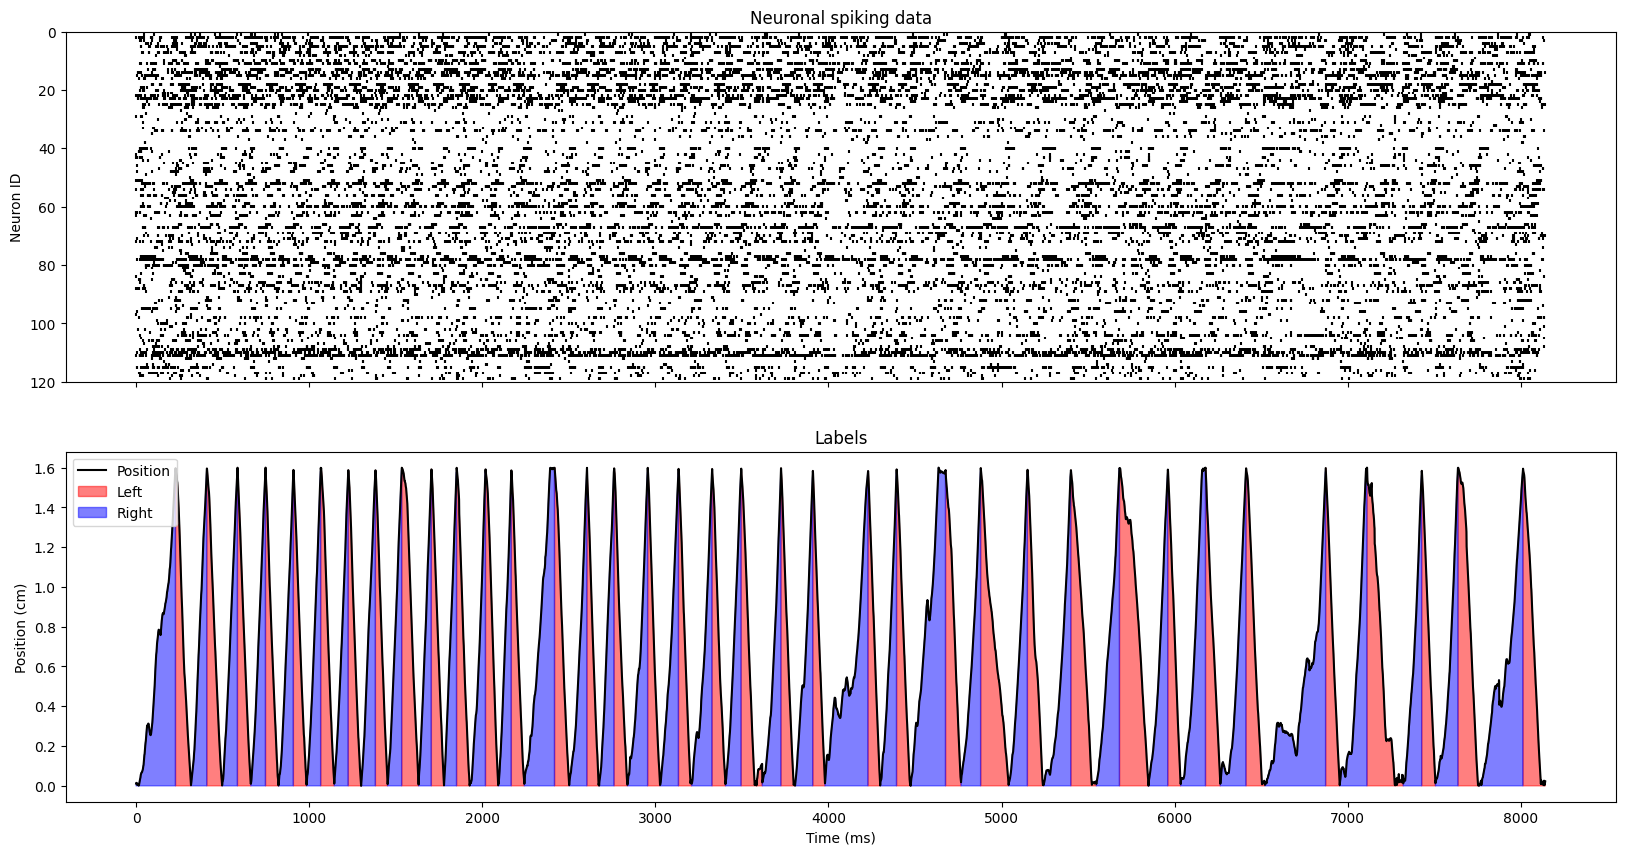

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)

for i in range(neural_train.shape[1]):
    spike_times = np.where(neural_train[:,i] > 0)[0]
    ax1.eventplot(spike_times, lineoffsets=i, colors='black')

ax1.set_ylabel('Neuron ID')
ax1.set_title('Neuronal spiking data')
# invert y-axis
ax1.set_ylim(neural_train.shape[1], 0)

ax2.plot(label_train[:,0], color='black')
ax2.fill_between(range(len(label_train)), label_train[:,0], where=label_train[:,2]==1, color='red', alpha=0.5)
ax2.fill_between(range(len(label_train)), label_train[:,0], where=label_train[:,1]==1, color='blue', alpha=0.5)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Position (cm)')
ax2.set_title('Labels')
plt.legend(['Position', 'Left', 'Right'])

plt.show()

### Train CEBRA-Behavior with position, or direction, and/or both variables

In [6]:
print(neural_train.shape)

(8142, 120)


In [7]:
cebra_posdir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [52]:
# Train CEBRA-Behavior models with both position and direction variables.
cebra_posdir_model.fit(neural_train, label_train)
cebra_posdir_model.save("cebra_posdir_model.pt")

# Train CEBRA-Behavior models with position or direction variable.
cebra_pos_model.fit(neural_train, label_train[:,0])
cebra_pos_model.save("cebra_pos_model.pt")

cebra_dir_model.fit(neural_train, label_train[:,1])
cebra_dir_model.save("cebra_dir_model.pt")

pos:  0.1622 neg:  5.4297 total:  5.5920 temperature:  1.0000: 100%|██████████| 500/500 [00:12<00:00, 38.61it/s]
pos:  0.1514 neg:  5.4989 total:  5.6503 temperature:  1.0000: 100%|██████████| 500/500 [00:06<00:00, 75.97it/s]
pos:  0.0838 neg:  5.5914 total:  5.6752 temperature:  1.0000: 100%|██████████| 500/500 [00:06<00:00, 76.40it/s]


### Train shuffled CEBRA-Behavior with position, direction variables and both

In [65]:
cebra_posdir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [66]:
# Generate shuffled behavior labels for train set.
shuffled_posdir = np.random.permutation(label_train)
shuffled_pos = np.random.permutation(label_train[:,0])
shuffled_dir = np.random.permutation(label_train[:,1])


# Train the models with shuffled behavior variables
cebra_posdir_shuffled_model.fit(neural_train, shuffled_posdir)
cebra_posdir_shuffled_model.save("cebra_posdir_shuffled_model.pt")

cebra_pos_shuffled_model.fit(neural_train, shuffled_pos)
cebra_pos_shuffled_model.save("cebra_pos_shuffled_model.pt")

cebra_dir_shuffled_model.fit(neural_train, shuffled_dir)
cebra_dir_shuffled_model.save("cebra_dir_shuffled_model.pt")

pos:  0.3370 neg:  5.8157 total:  6.1527 temperature:  1.0000: 100%|██████████| 500/500 [00:06<00:00, 76.40it/s]
pos:  0.3318 neg:  5.8323 total:  6.1641 temperature:  1.0000: 100%|██████████| 500/500 [00:06<00:00, 75.96it/s]
pos:  0.2086 neg:  5.8008 total:  6.0095 temperature:  1.0000: 100%|██████████| 500/500 [00:06<00:00, 75.57it/s]


**------------------- END OF TRAINING SECTION -------------------**

## Load the models and get the corresponding embeddings

In [ ]:
# We get train set embedding and test set embedding.

cebra_posdir_model = cebra.CEBRA.load("cebra_posdir_model.pt")
cebra_posdir_train = cebra_posdir_model.transform(neural_train)
cebra_posdir_test = cebra_posdir_model.transform(neural_test)

cebra_pos_model = cebra.CEBRA.load("cebra_pos_model.pt")
cebra_pos_train = cebra_pos_model.transform(neural_train)
cebra_pos_test = cebra_pos_model.transform(neural_test)

cebra_dir_model = cebra.CEBRA.load("cebra_dir_model.pt")
cebra_dir_train = cebra_dir_model.transform(neural_train)
cebra_dir_test = cebra_dir_model.transform(neural_test)

# ... and similarily for models with shuffled variables

cebra_posdir_shuffled_model = cebra.CEBRA.load("cebra_posdir_shuffled_model.pt")
cebra_posdir_shuffled_train = cebra_posdir_shuffled_model.transform(neural_train)
cebra_posdir_shuffled_test = cebra_posdir_shuffled_model.transform(neural_test)

cebra_pos_shuffled_model = cebra.CEBRA.load("cebra_pos_shuffled_model.pt")
cebra_pos_shuffled_train = cebra_pos_shuffled_model.transform(neural_train)
cebra_pos_shuffled_test = cebra_pos_shuffled_model.transform(neural_test)

cebra_dir_shuffled_model = cebra.CEBRA.load("cebra_dir_shuffled_model.pt")
cebra_dir_shuffled_train = cebra_dir_shuffled_model.transform(neural_train)
cebra_dir_shuffled_test = cebra_dir_shuffled_model.transform(neural_test)

In [10]:
cebra_pos_all = cebra_pos_model.transform(hippocampus_pos.neural)
cebra_dir_all = cebra_dir_model.transform(hippocampus_pos.neural)
cebra_posdir_all = cebra_posdir_model.transform(hippocampus_pos.neural)

cebra_pos_shuffled_all = cebra_pos_shuffled_model.transform(hippocampus_pos.neural)
cebra_dir_shuffled_all = cebra_dir_shuffled_model.transform(hippocampus_pos.neural)
cebra_posdir_shuffled_all = cebra_posdir_shuffled_model.transform(hippocampus_pos.neural)

## Decode the labels from the embeddings
We evaluate decoding performance of the different hypothesis models.

In [11]:
import sklearn.metrics

# Define decoding function with kNN decoder. For a simple demo, we will use the fixed number of neighbors 36.
def decoding_pos_dir(embedding_train, embedding_test, label_train, label_test):
   pos_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")
   dir_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")

   pos_decoder.fit(embedding_train, label_train[:,0])
   dir_decoder.fit(embedding_train, label_train[:,1])

   pos_pred = pos_decoder.predict(embedding_test)
   dir_pred = dir_decoder.predict(embedding_test)

   prediction = np.stack([pos_pred, dir_pred],axis = 1)

   test_score = sklearn.metrics.r2_score(label_test[:,:2], prediction)
   pos_test_err = np.median(abs(prediction[:,0] - label_test[:, 0]))
   pos_test_score = sklearn.metrics.r2_score(label_test[:, 0], prediction[:,0])

   return test_score, pos_test_err, pos_test_score

### Decode the position and direction from the trained hypothesis models

In [12]:
cebra_posdir_decode = decoding_pos_dir(cebra_posdir_train, cebra_posdir_test, label_train, label_test)
cebra_pos_decode = decoding_pos_dir(cebra_pos_train, cebra_pos_test, label_train, label_test)
cebra_dir_decode = decoding_pos_dir(cebra_dir_train, cebra_dir_test, label_train, label_test)

cebra_posdir_shuffled_decode = decoding_pos_dir(cebra_posdir_shuffled_train, cebra_posdir_shuffled_test, label_train, label_test)
cebra_pos_shuffled_decode = decoding_pos_dir(cebra_pos_shuffled_train, cebra_pos_shuffled_test, label_train, label_test)
cebra_dir_shuffled_decode = decoding_pos_dir(cebra_dir_shuffled_train, cebra_dir_shuffled_test, label_train, label_test)

### Visualize the decoding results and loss - decoding performance

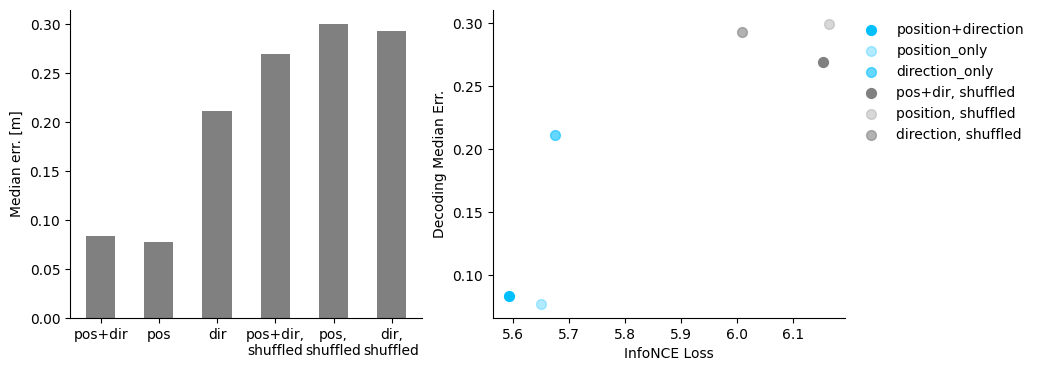

In [13]:
fig = plt.figure(figsize=(10,4))

ax1= plt.subplot(121)
ax1.bar(np.arange(6),
        [cebra_posdir_decode[1], cebra_pos_decode[1], cebra_dir_decode[1],
         cebra_posdir_shuffled_decode[1], cebra_pos_shuffled_decode[1], cebra_dir_shuffled_decode[1]],
         width = 0.5, color = 'gray')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(['pos+dir', 'pos', 'dir', 'pos+dir,\nshuffled', 'pos,\nshuffled', 'dir,\nshuffled'])
ax1.set_ylabel('Median err. [m]')

ax2 = plt.subplot(122)
ax2.scatter(cebra_posdir_model.state_dict_['loss'][-1],cebra_posdir_decode[1], s=50, c='deepskyblue', label = 'position+direction')
ax2.scatter(cebra_pos_model.state_dict_['loss'][-1],cebra_pos_decode[1], s=50, c='deepskyblue', alpha = 0.3, label = 'position_only')
ax2.scatter(cebra_dir_model.state_dict_['loss'][-1],cebra_dir_decode[1], s=50, c='deepskyblue', alpha=0.6,label = 'direction_only')
ax2.scatter(cebra_posdir_shuffled_model.state_dict_['loss'][-1],cebra_posdir_shuffled_decode[1], s=50, c='gray', label = 'pos+dir, shuffled')
ax2.scatter(cebra_pos_shuffled_model.state_dict_['loss'][-1],cebra_pos_shuffled_decode[1], s=50, c='gray', alpha = 0.3, label = 'position, shuffled')
ax2.scatter(cebra_dir_shuffled_model.state_dict_['loss'][-1],cebra_dir_shuffled_decode[1], s=50, c='gray', alpha=0.6,label = 'direction, shuffled')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('InfoNCE Loss')
ax2.set_ylabel('Decoding Median Err.')
plt.legend(bbox_to_anchor=(1,1), frameon = False )
plt.show()